# Задача 10

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.animation import FuncAnimation

sns.set_style("darkgrid")

%matplotlib notebook

### $\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}$, $0 < x < L$, $L = 1$

### $u(0, t) = 0$, $u(L, t) = 0$, $u(x, 0)=x(1 - x/L)^2$

In [2]:
def crank_nicolson(t: np.array, x: np.array, q0, qL, T0):
    assert x.size > 2 and t.size > 2
    h = x[1] - x[0]
    tau = t[1] - t[0]
    
    u = np.zeros((t.size, x.size))
    
    u[0,:] = T0(x)
    
    a_i = -tau / (2 * h ** 2)
    b_i = 1 + tau / h ** 2
    c_i = a_i
    
    alpha = np.zeros(x.size - 1)
    beta = np.zeros_like(alpha)

    for n in range(t.size - 1):
        alpha[0] = 0
        beta[0] = q0(t[n + 1])
        
        for j in range(1, x.size - 1):
            ksi_nj = u[n, j] + (tau / 2 / h ** 2) * (u[n, j + 1] - 2 * u[n, j] + u[n, j - 1])
            alpha[j] = -a_i / (b_i + c_i * alpha[j - 1])
            beta[j] = (ksi_nj - c_i * beta[j - 1]) / (b_i + c_i * alpha[j - 1])
        
        u[n + 1, x.size - 1] = qL(t[n + 1])
        
        for j in reversed(range(x.size - 1)):
            u[n + 1, j] = alpha[j] * u[n + 1, j + 1] + beta[j]
    
    return u

In [3]:
L = 1
N = 1000
T_max = 1

boundaryT = lambda t: 0

boundaryX = lambda x: x * (1 - x / L) ** 2

x = np.linspace(0, L, N)
t = np.linspace(0, T_max, N)

u = crank_nicolson(t, x, boundaryT, boundaryT, boundaryX)

<IPython.core.display.Javascript object>


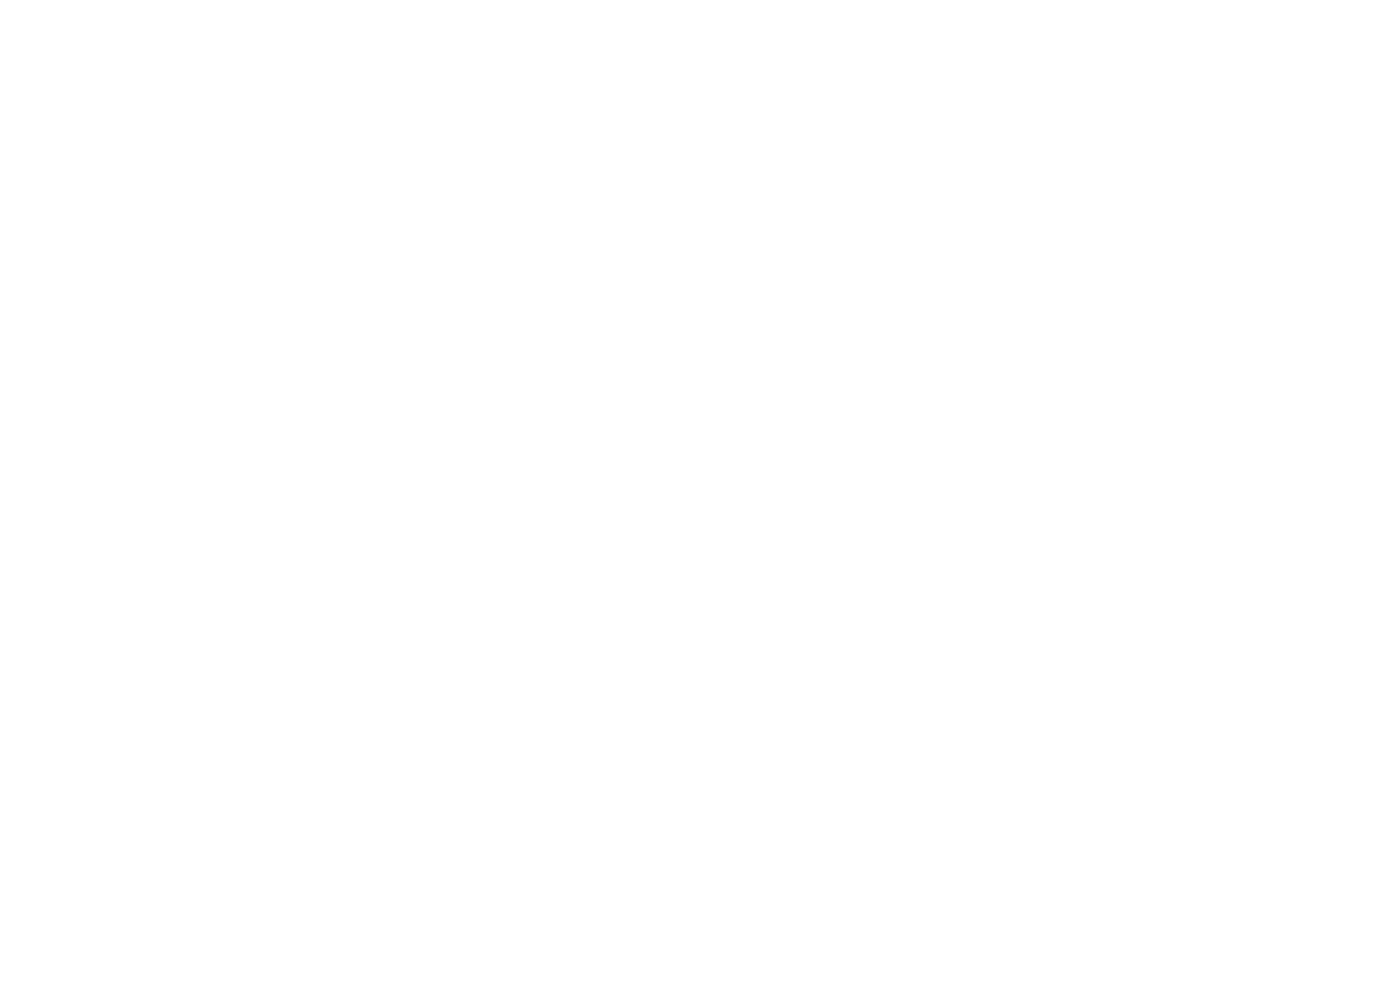

In [4]:
fig = plt.figure(1, figsize=(7, 5))

ax = plt.axes(xlim=(0, L), ylim=(0, np.max(u)))
ax.set_title("Heat Equation")

line, = ax.plot([], [])

ax.set_xlabel(r"X $\rightarrow$")
ax.set_ylabel(r"Temp $\rightarrow$")

frames_num = 200

def init():
    line.set_data([], [])
    return line,

def animate(i):
    temperature = u[i,:]
    
    line.set_data(x, temperature)
#     ax.set_title(f"Time: {i} sec")
    ax.set_title(f"Time: {T_max * (i / frames_num):.2f} sec")
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                     frames=frames_num, interval=10, blit=True)

plt.show()

<IPython.core.display.Javascript object>


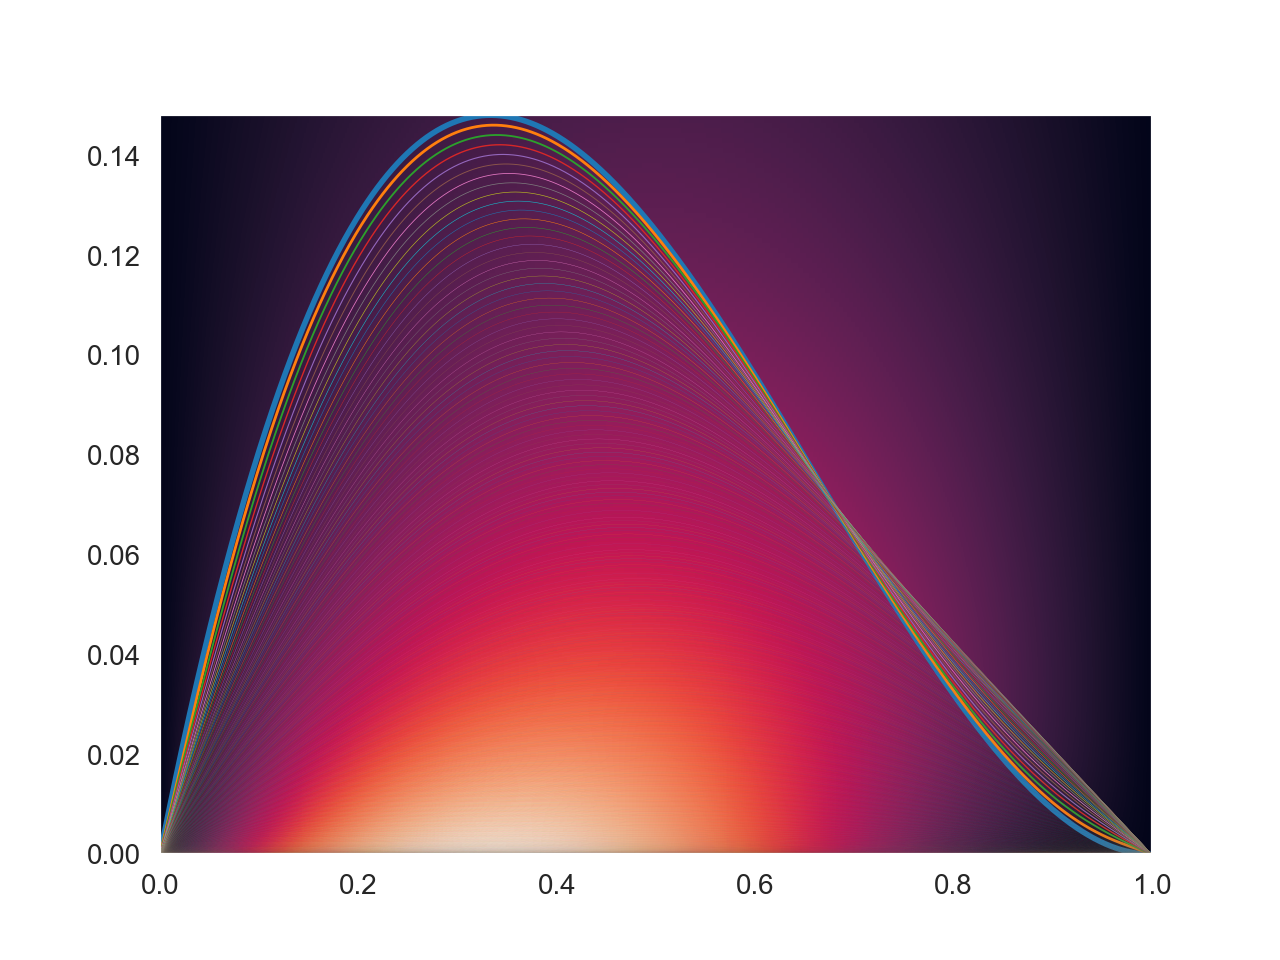

In [24]:
plt.figure(2)
ax2 = plt.axes(xlim=(0, L), ylim=(0, np.max(u)))
ax2.pcolormesh(x, t, u, shading='auto')
for i in range(t.size):
    ax2.plot(x, u[i, :], lw=(2/(i + 1)))
    
# plt.xlim((0, L))
ax2.ylim=((0, np.max(u)))
plt.show()

thanks to: https://www.youtube.com/watch?v=VBn1diQCykQ

analytic solution is:

# $u(x, t) = \Sigma_1^\infty \frac{4L}{\pi^4n^4}(2\pi n - 3\sin{\pi n} + \pi n \cos{\pi n})\sin{\frac{\pi n L}{x}} exp(-\frac{\pi^2 n^2}{L^2} t)$ 

In [16]:
def analyticSolution(L=1, N=int(1e2)):
    
    def A_n(n):
        return ((4 * L) / (np.pi**4 * n**4)) * (2 * np.pi * n - 3 * np.sin(np.pi * n) + np.pi * n * np.cos(np.pi * n))
    def u_x(x, n):
        return np.sin(np.pi * n * L / x)
    def u_t(t, n): 
        return np.exp(-t * (np.pi * n / L)**2)
    
    def u_xtn(x, y, n):  
        return A_n(n) * u_x(x, n) * u_t(t, n)
    
    solution = 0
    for n in range(1, N):
        solution += lambda x, t: u_xtn(x,t, n)
#   solution = np.vectorize(u_xtn)(np.linspace(1, N, N)) works slower... wtf actually
    return lambda x,t, : np.sum(solution(x, t))